# CBAM-ResNet50: Attention-Gated Hybrid CNN for Cervical Cancer Cell Classification

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Meet2304/Project-Phoenix/blob/main/Fine%20Tuning/4_Attention_Based_Models/CBAM_ResNet50_Cervical_Classification.ipynb)

---

## Overview

This notebook implements an **Attention-Gated Hybrid CNN** architecture combining:
- **Backbone**: ResNet50 (pretrained on ImageNet)
- **Attention Mechanism**: CBAM (Convolutional Block Attention Module)

### What is CBAM?

**CBAM** (Convolutional Block Attention Module) is a simple yet effective attention module that can be integrated into any CNN architecture. It sequentially applies:

1. **Channel Attention Module (CAM)**: Focuses on "what" is meaningful
   - Uses both max-pooling and average-pooling to aggregate spatial information
   - Generates a channel attention map to emphasize important feature channels

2. **Spatial Attention Module (SAM)**: Focuses on "where" is meaningful
   - Uses max and average pooling across channels
   - Generates a spatial attention map to focus on important regions (e.g., cell nucleus)

### Why CBAM for Cervical Cancer Classification?

- **Nucleus-Focused**: Forces the network to focus on the cell nucleus while ignoring background artifacts (blood, mucus)
- **Interpretable**: Attention maps provide visual explanations of "where" the model is looking
- **Lightweight**: Adds minimal computational overhead (~0.5% parameters)
- **Proven Effectiveness**: Improves performance across various vision tasks

### Architecture Overview

```
Input Image (224x224x3)
    ↓
Conv1 + BatchNorm + ReLU + MaxPool
    ↓
Layer 1 (3 ResNet Blocks) → CBAM
    ↓
Layer 2 (4 ResNet Blocks) → CBAM
    ↓
Layer 3 (6 ResNet Blocks) → CBAM
    ↓
Layer 4 (3 ResNet Blocks) → CBAM
    ↓
Global Average Pooling
    ↓
Fully Connected (5 classes)
```

---

## Dataset Structure

```
Augmented Dataset - Limited Enhancement/
├── im_Dyskeratotic/
│   └── NLM_CLAHE/
│       └── *.bmp
├── im_Koilocytotic/
│   └── NLM_CLAHE/
│       └── *.bmp
├── im_Metaplastic/
│   └── NLM_CLAHE/
│       └── *.bmp
├── im_Parabasal/
│   └── NLM_CLAHE/
│       └── *.bmp
└── im_Superficial-Intermediate/
    └── NLM_CLAHE/
        └── *.bmp
```

### Cell Classes

1. **Dyskeratotic**: Abnormal keratinization (pre-cancerous)
2. **Koilocytotic**: HPV-infected cells with perinuclear halos
3. **Metaplastic**: Transformed cells
4. **Parabasal**: Immature basal cells
5. **Superficial-Intermediate**: Normal mature cells

---

## 1. Environment Setup and Dependencies

In [2]:
# Mount Google Drive (for Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
except:
    IN_COLAB = False
    print("Not running in Colab - skipping drive mount")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Install required packages
!pip install -q torch torchvision torchaudio
!pip install -q scikit-learn pandas numpy matplotlib seaborn
!pip install -q pillow tqdm
!pip install -q grad-cam opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
# Import core libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from torchvision.models import ResNet50_Weights

# Data processing
import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Utilities
import warnings
import os
import random
import cv2

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: Tesla T4
Memory: 15.83 GB


## 2. Dataset Configuration and Loading

In [5]:
# Dataset path configuration
if IN_COLAB:
    DATASET_PARENT = Path(
        "/content/drive/MyDrive/Augmented Dataset - Limited Enhancement"
    )
else:
    # Adjust this path for your local setup
    DATASET_PARENT = Path("./Augmented Dataset - Limited Enhancement")

print(f"Dataset directory: {DATASET_PARENT}")
print(f"Exists: {DATASET_PARENT.exists()}")

Dataset directory: /content/drive/MyDrive/Augmented Dataset - Limited Enhancement
Exists: True


In [6]:
# Find all NLM_CLAHE directories (case-insensitive)
nlm_dirs = set()

# Immediate child search: look for <class>/NLM_CLAHE
for child in DATASET_PARENT.iterdir():
    if not child.is_dir():
        continue
    for sub in child.iterdir():
        if sub.is_dir() and sub.name.lower() == "nlm_clahe":
            nlm_dirs.add(sub.resolve())
            break

# Recursive fallback
for p in DATASET_PARENT.rglob("*"):
    if p.is_dir() and p.name.lower() == "nlm_clahe":
        nlm_dirs.add(p.resolve())

if not nlm_dirs:
    raise FileNotFoundError(
        "No 'NLM_CLAHE' directories found. Check folder names and path."
    )

print(f"Found {len(nlm_dirs)} NLM_CLAHE directories")

Found 5 NLM_CLAHE directories


In [7]:
# Collect BMP files from each NLM_CLAHE directory
rows = []
seen_paths = set()

for nlm in sorted(nlm_dirs, key=lambda x: str(x)):
    class_name = nlm.parent.name
    bmp_files = [p.resolve() for p in nlm.iterdir() if p.is_file() and p.suffix.lower() == ".bmp"]

    if not bmp_files:
        print(f"Warning: no .bmp files in {nlm} (class: {class_name})")
        continue

    for p in bmp_files:
        sp = str(p)
        if sp in seen_paths:
            continue
        seen_paths.add(sp)
        rows.append((sp, class_name))

# Build DataFrame
df = pd.DataFrame(rows, columns=["image_path", "label_name"])

if df.empty:
    raise RuntimeError("No .bmp image files found in any NLM_CLAHE directories.")

# Create stable class ordering and integer labels
class_names = sorted(df["label_name"].unique().tolist())
label_to_id = {name: i for i, name in enumerate(class_names)}
id_to_label = {i: name for i, name in enumerate(class_names)}
df["label"] = df["label_name"].map(label_to_id)

# Shuffle
df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)

# Display summary
print(f"\nTotal images: {len(df)}")
print(f"\nClasses ({len(class_names)}):")
for i, name in enumerate(class_names):
    count = len(df[df['label'] == i])
    print(f"  {i}: {name:35s} - {count:4d} images")

print("\nClass distribution:")
print(df.groupby("label_name").size().sort_values(ascending=False))


Total images: 4049

Classes (5):
  0: im_Dyskeratotic                     -  813 images
  1: im_Koilocytotic                     -  825 images
  2: im_Metaplastic                      -  793 images
  3: im_Parabasal                        -  787 images
  4: im_Superficial-Intermediate         -  831 images

Class distribution:
label_name
im_Superficial-Intermediate    831
im_Koilocytotic                825
im_Dyskeratotic                813
im_Metaplastic                 793
im_Parabasal                   787
dtype: int64


In [8]:
# Stratified train/val/test split (80/10/10)
train_df, temp_df = train_test_split(
    df, test_size=0.2, stratify=df['label'], random_state=SEED
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['label'], random_state=SEED
)

print(f"Train set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")

print("\nTrain class distribution:")
print(train_df['label_name'].value_counts().sort_index())

print("\nValidation class distribution:")
print(val_df['label_name'].value_counts().sort_index())

print("\nTest class distribution:")
print(test_df['label_name'].value_counts().sort_index())

Train set: 3239 images
Validation set: 405 images
Test set: 405 images

Train class distribution:
label_name
im_Dyskeratotic                650
im_Koilocytotic                660
im_Metaplastic                 634
im_Parabasal                   630
im_Superficial-Intermediate    665
Name: count, dtype: int64

Validation class distribution:
label_name
im_Dyskeratotic                81
im_Koilocytotic                83
im_Metaplastic                 79
im_Parabasal                   79
im_Superficial-Intermediate    83
Name: count, dtype: int64

Test class distribution:
label_name
im_Dyskeratotic                82
im_Koilocytotic                82
im_Metaplastic                 80
im_Parabasal                   78
im_Superficial-Intermediate    83
Name: count, dtype: int64


## 3. Data Augmentation and Dataset Class

In [9]:
# ImageNet statistics for normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Training transforms with aggressive augmentation
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Validation/test transforms (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

print("Transforms configured successfully")

Transforms configured successfully


In [10]:
# Custom Dataset class
class CervicalCellDataset(Dataset):
    """Dataset class for cervical cell images."""

    def __init__(self, dataframe, transform=None):
        """
        Args:
            dataframe: DataFrame with 'image_path' and 'label' columns
            transform: Optional transform to apply to images
        """
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        label = self.dataframe.iloc[idx]['label']

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, label

# Create datasets
train_dataset = CervicalCellDataset(train_df, transform=train_transform)
val_dataset = CervicalCellDataset(val_df, transform=val_transform)
test_dataset = CervicalCellDataset(test_df, transform=val_transform)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 3239
Validation dataset size: 405
Test dataset size: 405


In [11]:
# Create dataloaders with weighted sampling for balanced training
BATCH_SIZE = 32
NUM_WORKERS = 2 if IN_COLAB else 0

# Calculate class weights for balanced sampling
class_counts = train_df['label'].value_counts().sort_index().values
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)
sample_weights = class_weights[train_df['label'].values]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"\nDataLoaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")
print(f"  Batch size: {BATCH_SIZE}")


DataLoaders created:
  Train batches: 102
  Val batches: 13
  Test batches: 13
  Batch size: 32


## 4. CBAM (Convolutional Block Attention Module) Implementation

In [12]:
class ChannelAttention(nn.Module):
    """Channel Attention Module - focuses on 'what' is meaningful."""

    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        # Shared MLP
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction_ratio, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction_ratio, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Average pooling branch
        avg_out = self.fc(self.avg_pool(x))
        # Max pooling branch
        max_out = self.fc(self.max_pool(x))
        # Combine and apply sigmoid
        out = self.sigmoid(avg_out + max_out)
        return x * out


class SpatialAttention(nn.Module):
    """Spatial Attention Module - focuses on 'where' is meaningful."""

    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Channel-wise statistics
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        # Concatenate and convolve
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.sigmoid(self.conv(out))
        return x * out


class CBAM(nn.Module):
    """Convolutional Block Attention Module (CBAM).

    Sequentially applies channel attention followed by spatial attention.
    Paper: "CBAM: Convolutional Block Attention Module" (Woo et al., ECCV 2018)
    """

    def __init__(self, in_channels, reduction_ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction_ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        # Apply channel attention first
        x = self.channel_attention(x)
        # Then apply spatial attention
        x = self.spatial_attention(x)
        return x


print("CBAM modules defined successfully")

# Test CBAM module
test_input = torch.randn(1, 256, 56, 56)
cbam = CBAM(256)
test_output = cbam(test_input)
print(f"Test input shape: {test_input.shape}")
print(f"Test output shape: {test_output.shape}")
print(f"CBAM parameters: {sum(p.numel() for p in cbam.parameters()):,}")

CBAM modules defined successfully
Test input shape: torch.Size([1, 256, 56, 56])
Test output shape: torch.Size([1, 256, 56, 56])
CBAM parameters: 8,290


## 5. CBAM-ResNet50 Model Architecture

In [13]:
class CBAM_ResNet50(nn.Module):
    """ResNet50 with CBAM attention modules inserted after each residual layer.

    This architecture:
    1. Uses pretrained ResNet50 as backbone
    2. Inserts CBAM after each of the 4 main residual layers
    3. Fine-tunes the entire network for cervical cell classification
    """

    def __init__(self, num_classes=5, pretrained=True):
        super(CBAM_ResNet50, self).__init__()

        # Load pretrained ResNet50
        if pretrained:
            weights = ResNet50_Weights.IMAGENET1K_V2
            resnet = models.resnet50(weights=weights)
            print("Loaded pretrained ResNet50 weights (ImageNet)")
        else:
            resnet = models.resnet50(weights=None)
            print("Initialized ResNet50 without pretrained weights")

        # Extract layers from ResNet50
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool

        # ResNet layers with their output channels
        self.layer1 = resnet.layer1  # Output: 256 channels
        self.cbam1 = CBAM(256)

        self.layer2 = resnet.layer2  # Output: 512 channels
        self.cbam2 = CBAM(512)

        self.layer3 = resnet.layer3  # Output: 1024 channels
        self.cbam3 = CBAM(1024)

        self.layer4 = resnet.layer4  # Output: 2048 channels
        self.cbam4 = CBAM(2048)

        # Global pooling and classifier
        self.avgpool = resnet.avgpool
        self.fc = nn.Linear(2048, num_classes)

        # Initialize the new classifier layer
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)

    def forward(self, x, return_attention=False):
        """Forward pass with optional attention map extraction.

        Args:
            x: Input tensor (B, 3, 224, 224)
            return_attention: If True, returns intermediate attention maps

        Returns:
            logits: Classification logits (B, num_classes)
            attention_maps: Dict of attention maps (if return_attention=True)
        """
        attention_maps = {} if return_attention else None

        # Initial convolution
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Layer 1 + CBAM
        x = self.layer1(x)
        if return_attention:
            attention_maps['layer1_before'] = x.clone()
        x = self.cbam1(x)
        if return_attention:
            attention_maps['layer1_after'] = x.clone()

        # Layer 2 + CBAM
        x = self.layer2(x)
        if return_attention:
            attention_maps['layer2_before'] = x.clone()
        x = self.cbam2(x)
        if return_attention:
            attention_maps['layer2_after'] = x.clone()

        # Layer 3 + CBAM
        x = self.layer3(x)
        if return_attention:
            attention_maps['layer3_before'] = x.clone()
        x = self.cbam3(x)
        if return_attention:
            attention_maps['layer3_after'] = x.clone()

        # Layer 4 + CBAM
        x = self.layer4(x)
        if return_attention:
            attention_maps['layer4_before'] = x.clone()
        x = self.cbam4(x)
        if return_attention:
            attention_maps['layer4_after'] = x.clone()

        # Global pooling and classification
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        logits = self.fc(x)

        if return_attention:
            return logits, attention_maps
        return logits


# Instantiate model
model = CBAM_ResNet50(num_classes=len(class_names), pretrained=True)
model = model.to(device)

# Calculate model parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel: CBAM-ResNet50")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Number of classes: {len(class_names)}")

# Test forward pass
test_input = torch.randn(2, 3, 224, 224).to(device)
test_output = model(test_input)
print(f"\nTest forward pass:")
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {test_output.shape}")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 209MB/s]


Loaded pretrained ResNet50 weights (ImageNet)

Model: CBAM-ResNet50
Total parameters: 24,214,989
Trainable parameters: 24,214,989
Number of classes: 5

Test forward pass:
Input shape: torch.Size([2, 3, 224, 224])
Output shape: torch.Size([2, 5])


## 6. Training Configuration

In [15]:
# Training hyperparameters
NUM_EPOCHS = 30
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
PATIENCE = 7  # For early stopping

# Loss function with class weights
class_weights_tensor = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizer - Adam with weight decay
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler - ReduceLROnPlateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3
)

print("Training configuration:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Weight decay: {WEIGHT_DECAY}")
print(f"  Optimizer: AdamW")
print(f"  Scheduler: ReduceLROnPlateau")
print(f"  Loss: CrossEntropyLoss (weighted)")
print(f"  Early stopping patience: {PATIENCE}")

Training configuration:
  Epochs: 30
  Learning rate: 0.0001
  Weight decay: 0.0001
  Optimizer: AdamW
  Scheduler: ReduceLROnPlateau
  Loss: CrossEntropyLoss (weighted)
  Early stopping patience: 7


## 7. Training and Validation Functions

In [16]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc='Training', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.0 * correct / total:.2f}%'
        })

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc


def validate(model, dataloader, criterion, device):
    """Validate the model."""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation', leave=False)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    epoch_loss = running_loss / len(all_labels)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    epoch_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    return epoch_loss, epoch_acc, epoch_precision, epoch_recall, epoch_f1


print("Training functions defined")

Training functions defined


## 8. Training Loop with Early Stopping

In [17]:
# Training history
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [],
    'val_precision': [], 'val_recall': [], 'val_f1': [],
    'learning_rates': []
}

# Early stopping
best_val_acc = 0.0
best_epoch = 0
patience_counter = 0
best_model_state = None

print("Starting training...\n")
print("=" * 80)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 80)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc, val_precision, val_recall, val_f1 = validate(
        model, val_loader, criterion, device
    )

    # Update learning rate
    scheduler.step(val_acc)
    current_lr = optimizer.param_groups[0]['lr']

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_precision'].append(val_precision)
    history['val_recall'].append(val_recall)
    history['val_f1'].append(val_f1)
    history['learning_rates'].append(current_lr)

    # Print metrics
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"Val Precision: {val_precision:.4f} | Val Recall: {val_recall:.4f} | Val F1: {val_f1:.4f}")
    print(f"Learning Rate: {current_lr:.2e}")

    # Check for best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        print(f"✓ New best model! (Val Acc: {best_val_acc:.4f})")
    else:
        patience_counter += 1
        print(f"Patience: {patience_counter}/{PATIENCE}")

    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

print("\n" + "=" * 80)
print("Training completed!")
print(f"Best validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Loaded best model weights")

Starting training...


Epoch 1/30
--------------------------------------------------------------------------------


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.8380 | Train Acc: 0.6869
Val Loss:   0.3183 | Val Acc:   0.9037
Val Precision: 0.9136 | Val Recall: 0.9037 | Val F1: 0.9017
Learning Rate: 1.00e-04
✓ New best model! (Val Acc: 0.9037)

Epoch 2/30
--------------------------------------------------------------------------------


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.3421 | Train Acc: 0.8774
Val Loss:   0.2455 | Val Acc:   0.9160
Val Precision: 0.9198 | Val Recall: 0.9160 | Val F1: 0.9139
Learning Rate: 1.00e-04
✓ New best model! (Val Acc: 0.9160)

Epoch 3/30
--------------------------------------------------------------------------------


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.2692 | Train Acc: 0.9052
Val Loss:   0.1751 | Val Acc:   0.9531
Val Precision: 0.9534 | Val Recall: 0.9531 | Val F1: 0.9531
Learning Rate: 1.00e-04
✓ New best model! (Val Acc: 0.9531)

Epoch 4/30
--------------------------------------------------------------------------------


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dc61bf2e520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dc61bf2e520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.2039 | Train Acc: 0.9247
Val Loss:   0.2067 | Val Acc:   0.9284
Val Precision: 0.9339 | Val Recall: 0.9284 | Val F1: 0.9276
Learning Rate: 1.00e-04
Patience: 1/7

Epoch 5/30
--------------------------------------------------------------------------------


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.2070 | Train Acc: 0.9247
Val Loss:   0.1986 | Val Acc:   0.9407
Val Precision: 0.9425 | Val Recall: 0.9407 | Val F1: 0.9397
Learning Rate: 1.00e-04
Patience: 2/7

Epoch 6/30
--------------------------------------------------------------------------------


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.1754 | Train Acc: 0.9358
Val Loss:   0.1511 | Val Acc:   0.9432
Val Precision: 0.9440 | Val Recall: 0.9432 | Val F1: 0.9433
Learning Rate: 1.00e-04
Patience: 3/7

Epoch 7/30
--------------------------------------------------------------------------------


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.1566 | Train Acc: 0.9447
Val Loss:   0.1313 | Val Acc:   0.9457
Val Precision: 0.9473 | Val Recall: 0.9457 | Val F1: 0.9460
Learning Rate: 5.00e-05
Patience: 4/7

Epoch 8/30
--------------------------------------------------------------------------------


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dc61bf2e520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dc61bf2e520>    if w.is_alive():
Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      self._shutdown_workers()  
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive():
 ^  ^ ^^ ^ ^  ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^ ^ ^ 
   File "/usr/lib/

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.1155 | Train Acc: 0.9602
Val Loss:   0.1294 | Val Acc:   0.9531
Val Precision: 0.9551 | Val Recall: 0.9531 | Val F1: 0.9527
Learning Rate: 5.00e-05
Patience: 5/7

Epoch 9/30
--------------------------------------------------------------------------------


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.1138 | Train Acc: 0.9605
Val Loss:   0.1263 | Val Acc:   0.9531
Val Precision: 0.9543 | Val Recall: 0.9531 | Val F1: 0.9526
Learning Rate: 5.00e-05
Patience: 6/7

Epoch 10/30
--------------------------------------------------------------------------------


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.0995 | Train Acc: 0.9660
Val Loss:   0.1404 | Val Acc:   0.9506
Val Precision: 0.9516 | Val Recall: 0.9506 | Val F1: 0.9505
Learning Rate: 5.00e-05
Patience: 7/7

Early stopping triggered at epoch 10

Training completed!
Best validation accuracy: 0.9531 at epoch 3
Loaded best model weights


## 9. Training Visualization

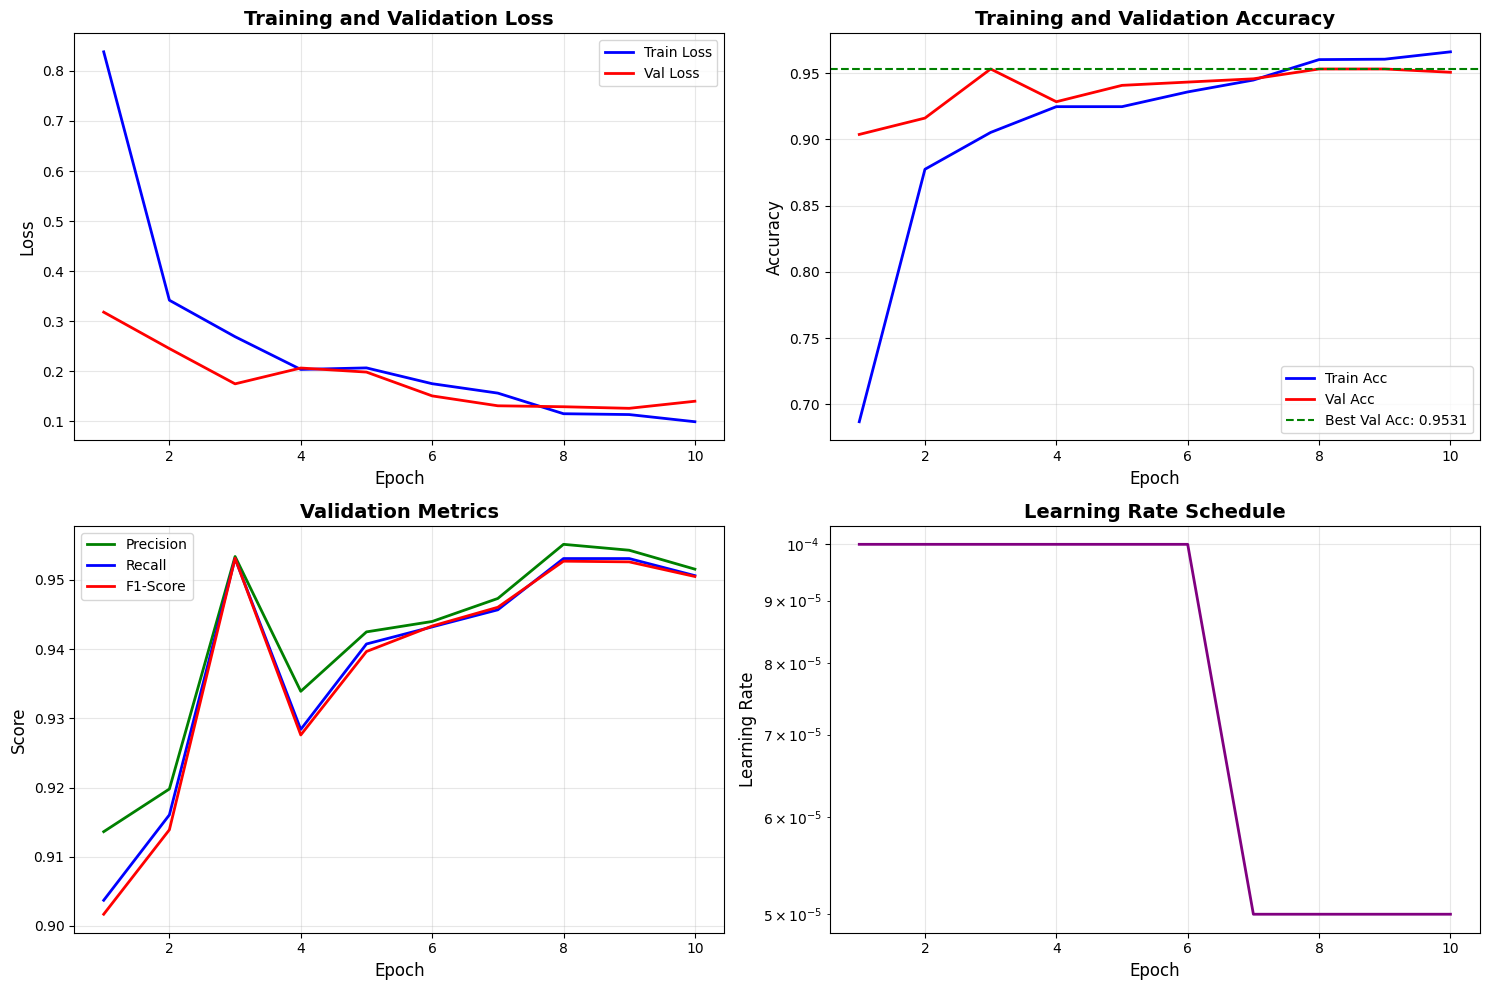

Training history plots saved


In [18]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

epochs_range = range(1, len(history['train_loss']) + 1)

# Loss
axes[0, 0].plot(epochs_range, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[0, 0].plot(epochs_range, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(epochs_range, history['train_acc'], 'b-', label='Train Acc', linewidth=2)
axes[0, 1].plot(epochs_range, history['val_acc'], 'r-', label='Val Acc', linewidth=2)
axes[0, 1].axhline(y=best_val_acc, color='g', linestyle='--', label=f'Best Val Acc: {best_val_acc:.4f}')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Metrics
axes[1, 0].plot(epochs_range, history['val_precision'], 'g-', label='Precision', linewidth=2)
axes[1, 0].plot(epochs_range, history['val_recall'], 'b-', label='Recall', linewidth=2)
axes[1, 0].plot(epochs_range, history['val_f1'], 'r-', label='F1-Score', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Score', fontsize=12)
axes[1, 0].set_title('Validation Metrics', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Learning Rate
axes[1, 1].plot(epochs_range, history['learning_rates'], 'purple', linewidth=2)
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Learning Rate', fontsize=12)
axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training history plots saved")

## 10. Test Set Evaluation

In [19]:
def evaluate_model(model, dataloader, device, class_names):
    """Comprehensive model evaluation."""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Evaluating'):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    # Per-class metrics
    print("\n" + "=" * 80)
    print("TEST SET EVALUATION RESULTS")
    print("=" * 80)
    print(f"\nOverall Metrics:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

    print("\n" + "-" * 80)
    print("Classification Report:")
    print("-" * 80)
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    return all_labels, all_preds, all_probs


# Evaluate on test set
test_labels, test_preds, test_probs = evaluate_model(model, test_loader, device, class_names)

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


TEST SET EVALUATION RESULTS

Overall Metrics:
  Accuracy:  0.9432
  Precision: 0.9440
  Recall:    0.9432
  F1-Score:  0.9434

--------------------------------------------------------------------------------
Classification Report:
--------------------------------------------------------------------------------
                             precision    recall  f1-score   support

            im_Dyskeratotic     0.9872    0.9390    0.9625        82
            im_Koilocytotic     0.8795    0.8902    0.8848        82
             im_Metaplastic     0.8902    0.9125    0.9012        80
               im_Parabasal     0.9873    1.0000    0.9936        78
im_Superficial-Intermediate     0.9759    0.9759    0.9759        83

                   accuracy                         0.9432       405
                  macro avg     0.9440    0.9435    0.9436       405
               weighted avg     0.9440    0.9432    0.9434       405



## 11. Confusion Matrix Visualization

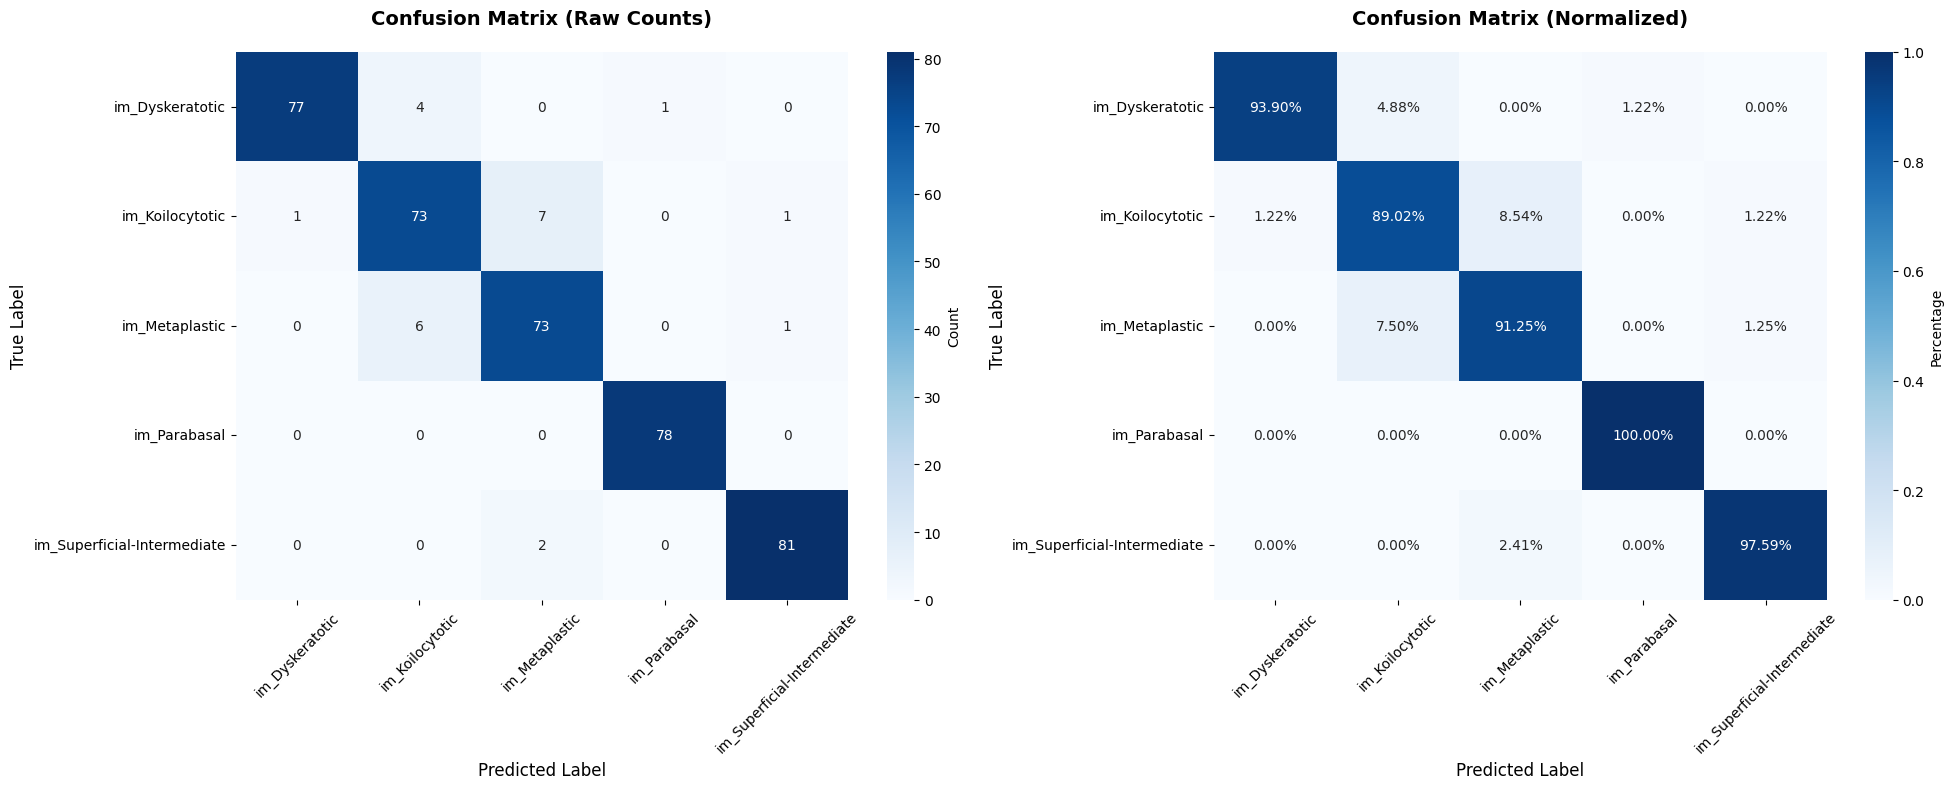

Confusion matrix plots saved


In [20]:
# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix (Raw Counts)', fontsize=14, fontweight='bold', pad=20)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Normalized
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[1], cbar_kws={'label': 'Percentage'})
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold', pad=20)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrix plots saved")

## 12. Per-Class Performance Analysis


Per-Class Performance Metrics:
                      Class  Accuracy  Precision   Recall  F1-Score  Support
            im_Dyskeratotic  0.939024   0.987179 0.939024  0.962500       82
            im_Koilocytotic  0.890244   0.879518 0.890244  0.884848       82
             im_Metaplastic  0.912500   0.890244 0.912500  0.901235       80
               im_Parabasal  1.000000   0.987342 1.000000  0.993631       78
im_Superficial-Intermediate  0.975904   0.975904 0.975904  0.975904       83


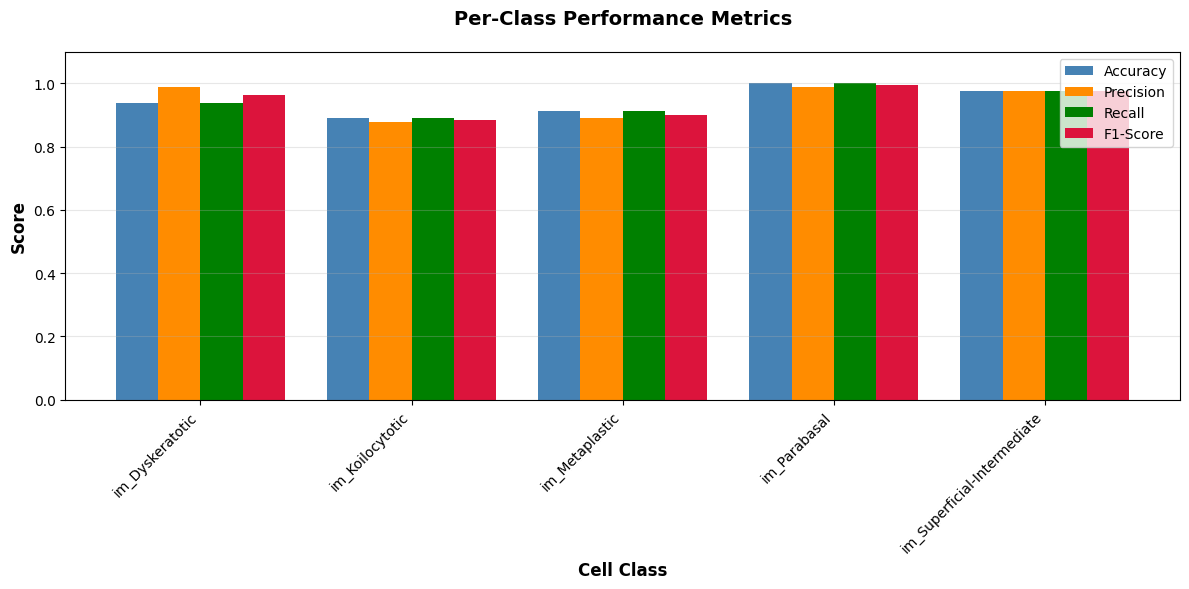

In [21]:
# Calculate per-class metrics
per_class_acc = []
per_class_precision = precision_score(test_labels, test_preds, average=None, zero_division=0)
per_class_recall = recall_score(test_labels, test_preds, average=None, zero_division=0)
per_class_f1 = f1_score(test_labels, test_preds, average=None, zero_division=0)

for i in range(len(class_names)):
    mask = test_labels == i
    if mask.sum() > 0:
        per_class_acc.append((test_preds[mask] == test_labels[mask]).mean())
    else:
        per_class_acc.append(0.0)

# Create DataFrame
metrics_df = pd.DataFrame({
    'Class': class_names,
    'Accuracy': per_class_acc,
    'Precision': per_class_precision,
    'Recall': per_class_recall,
    'F1-Score': per_class_f1,
    'Support': [np.sum(test_labels == i) for i in range(len(class_names))]
})

print("\nPer-Class Performance Metrics:")
print("=" * 100)
print(metrics_df.to_string(index=False))
print("=" * 100)

# Visualize per-class metrics
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(class_names))
width = 0.2

ax.bar(x - 1.5*width, per_class_acc, width, label='Accuracy', color='steelblue')
ax.bar(x - 0.5*width, per_class_precision, width, label='Precision', color='darkorange')
ax.bar(x + 0.5*width, per_class_recall, width, label='Recall', color='green')
ax.bar(x + 1.5*width, per_class_f1, width, label='F1-Score', color='crimson')

ax.set_xlabel('Cell Class', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.legend(fontsize=10)
ax.set_ylim([0, 1.1])
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('per_class_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

## 13. Attention Map Visualization

Generating attention visualizations...



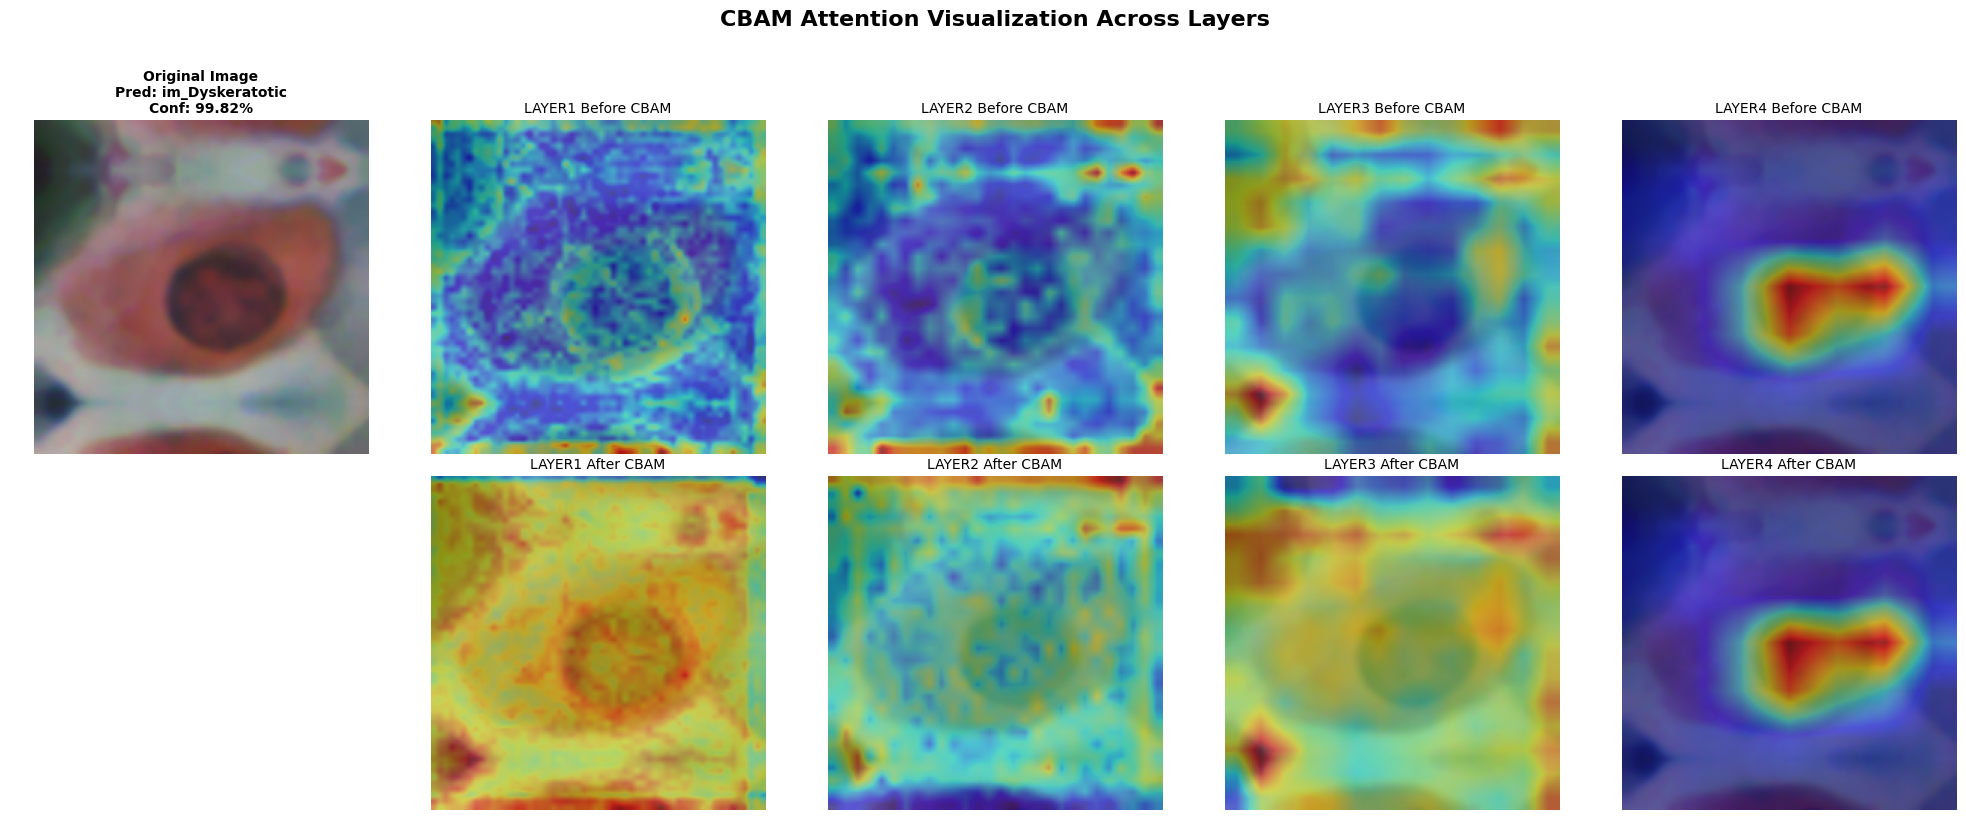

Saved attention map for im_Dyskeratotic


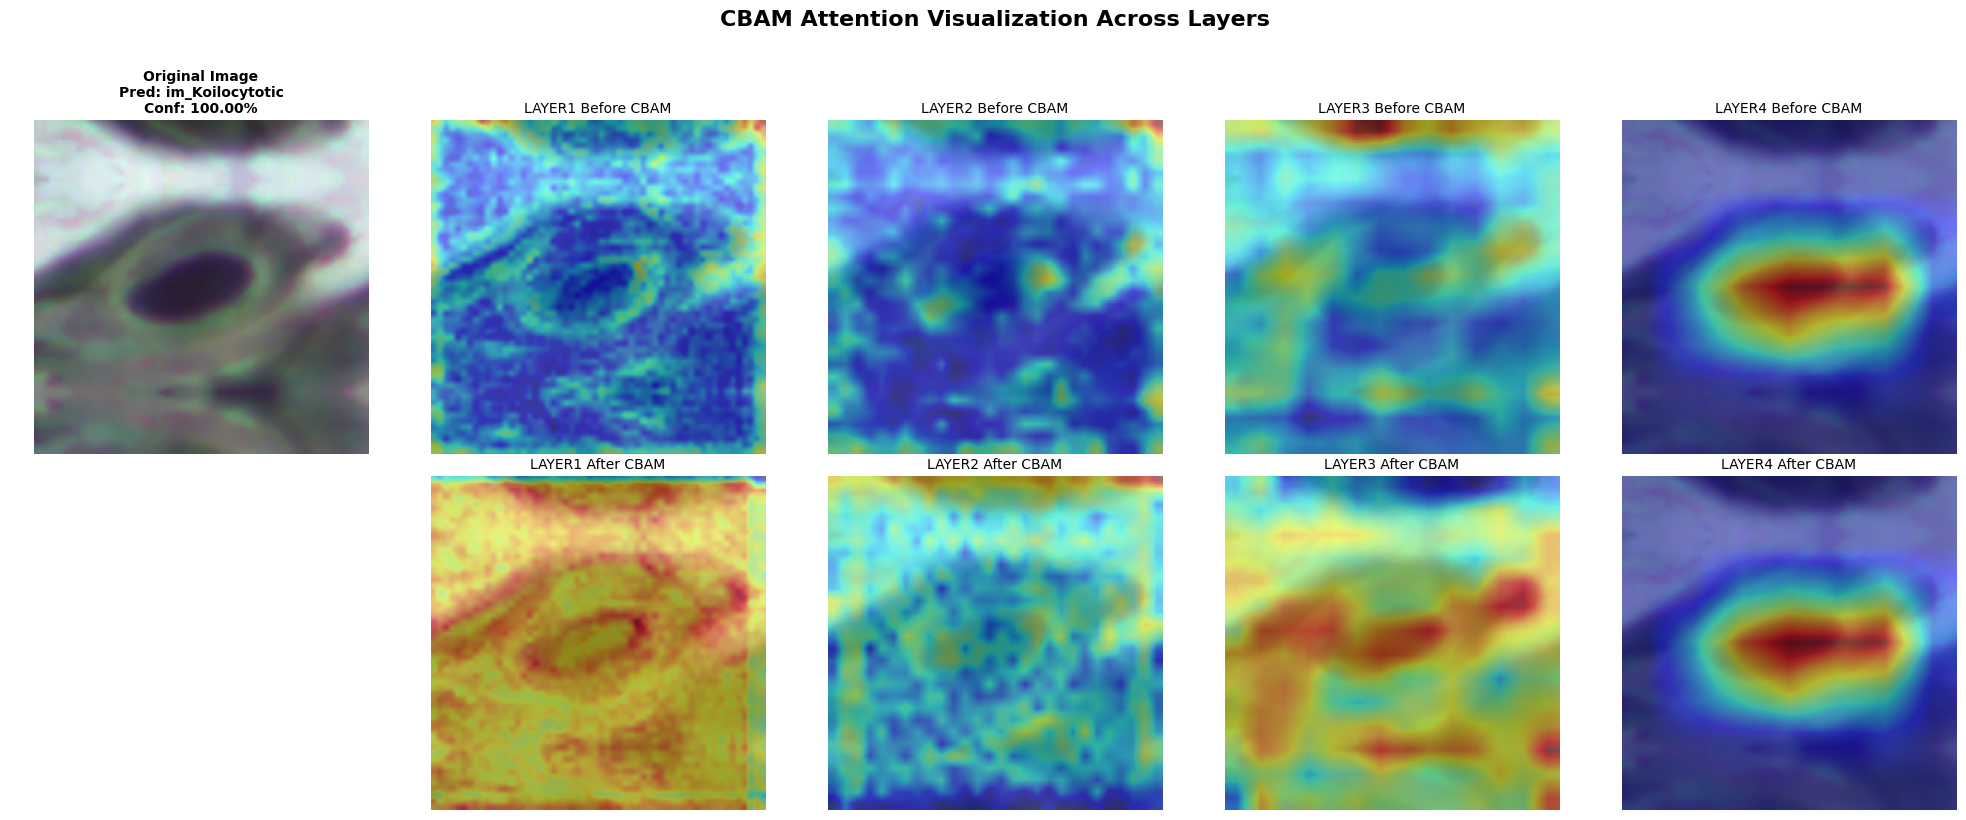

Saved attention map for im_Koilocytotic


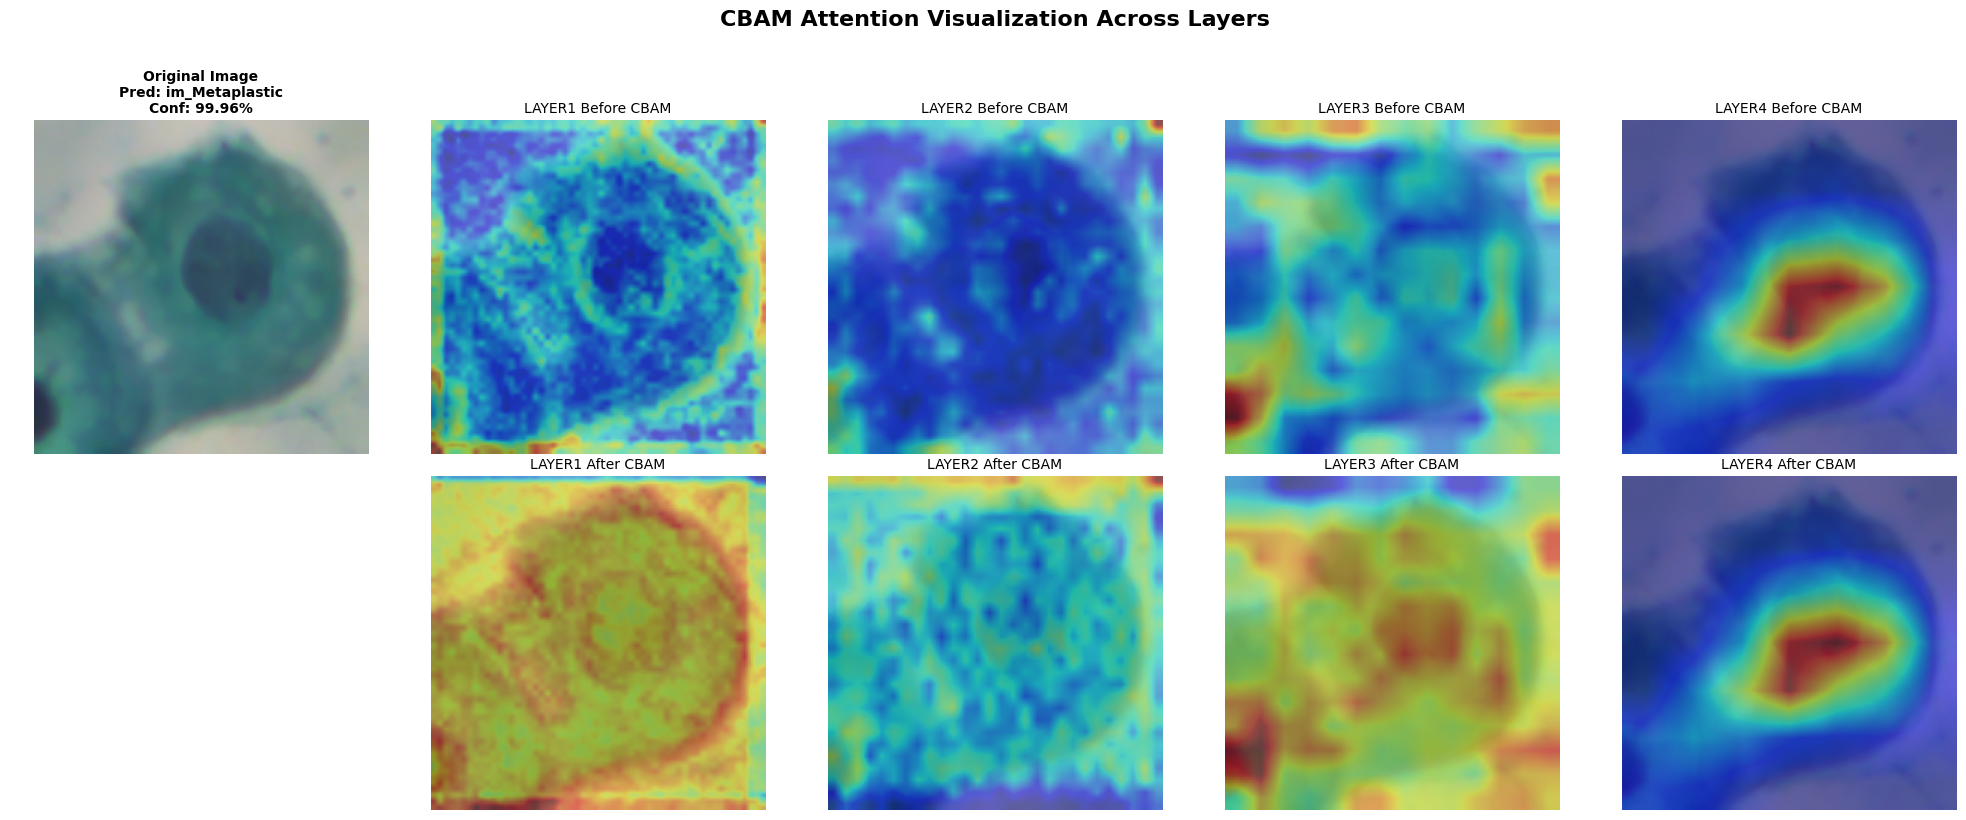

Saved attention map for im_Metaplastic


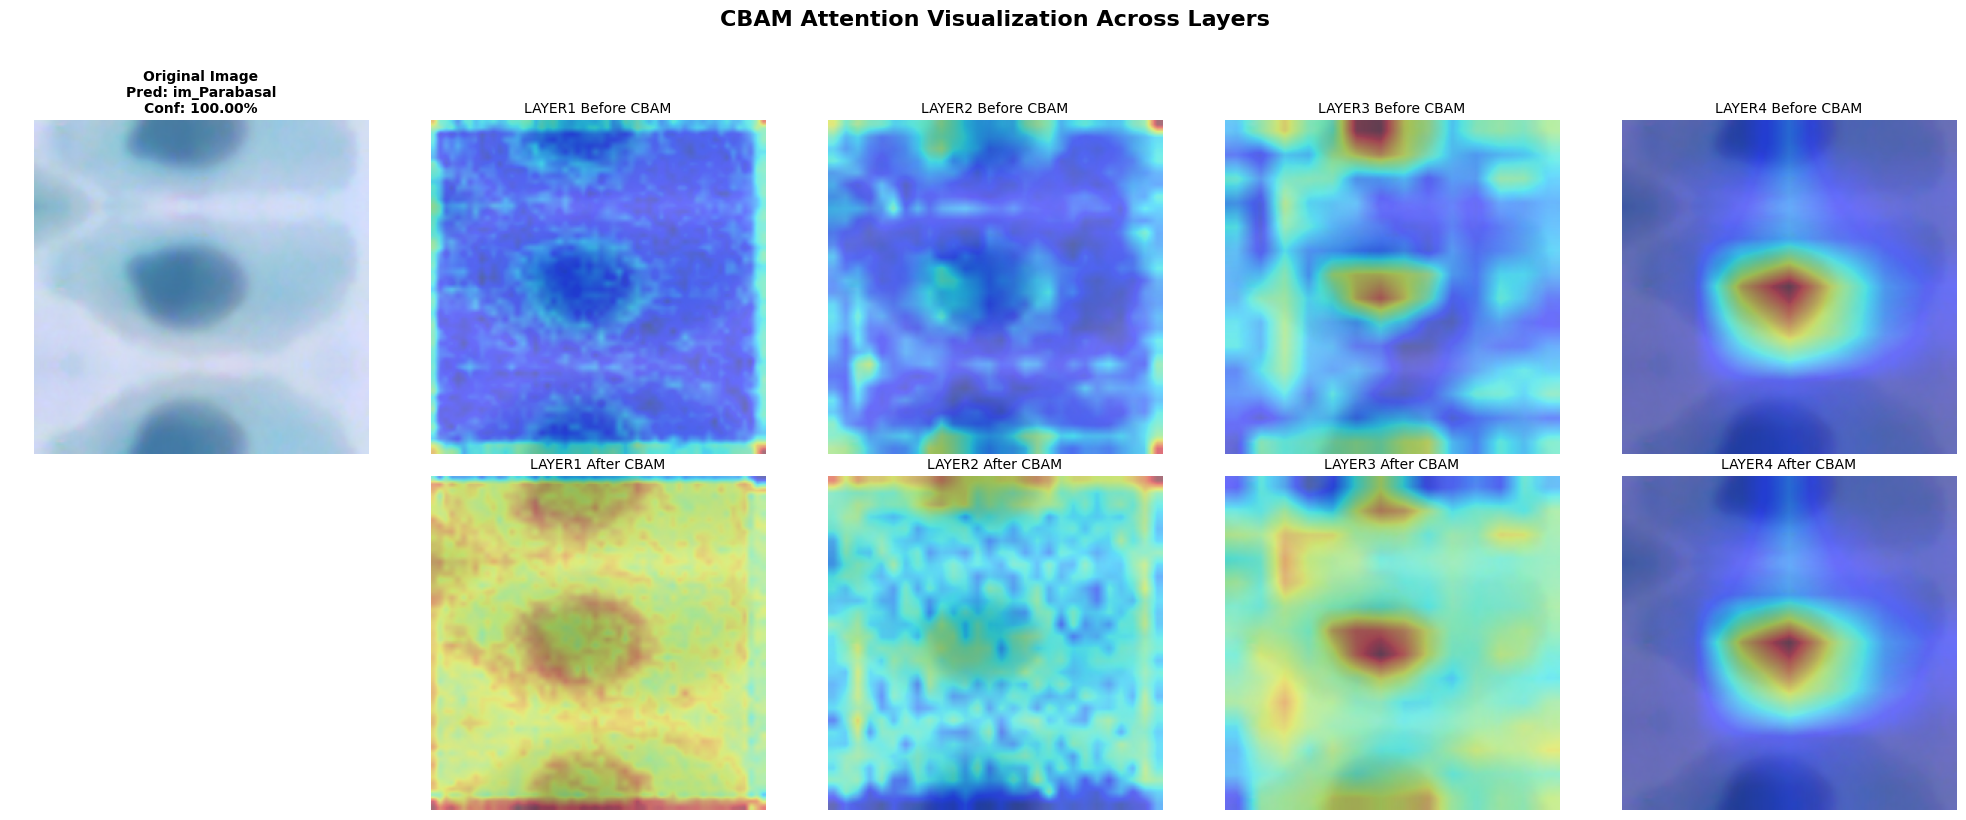

Saved attention map for im_Parabasal


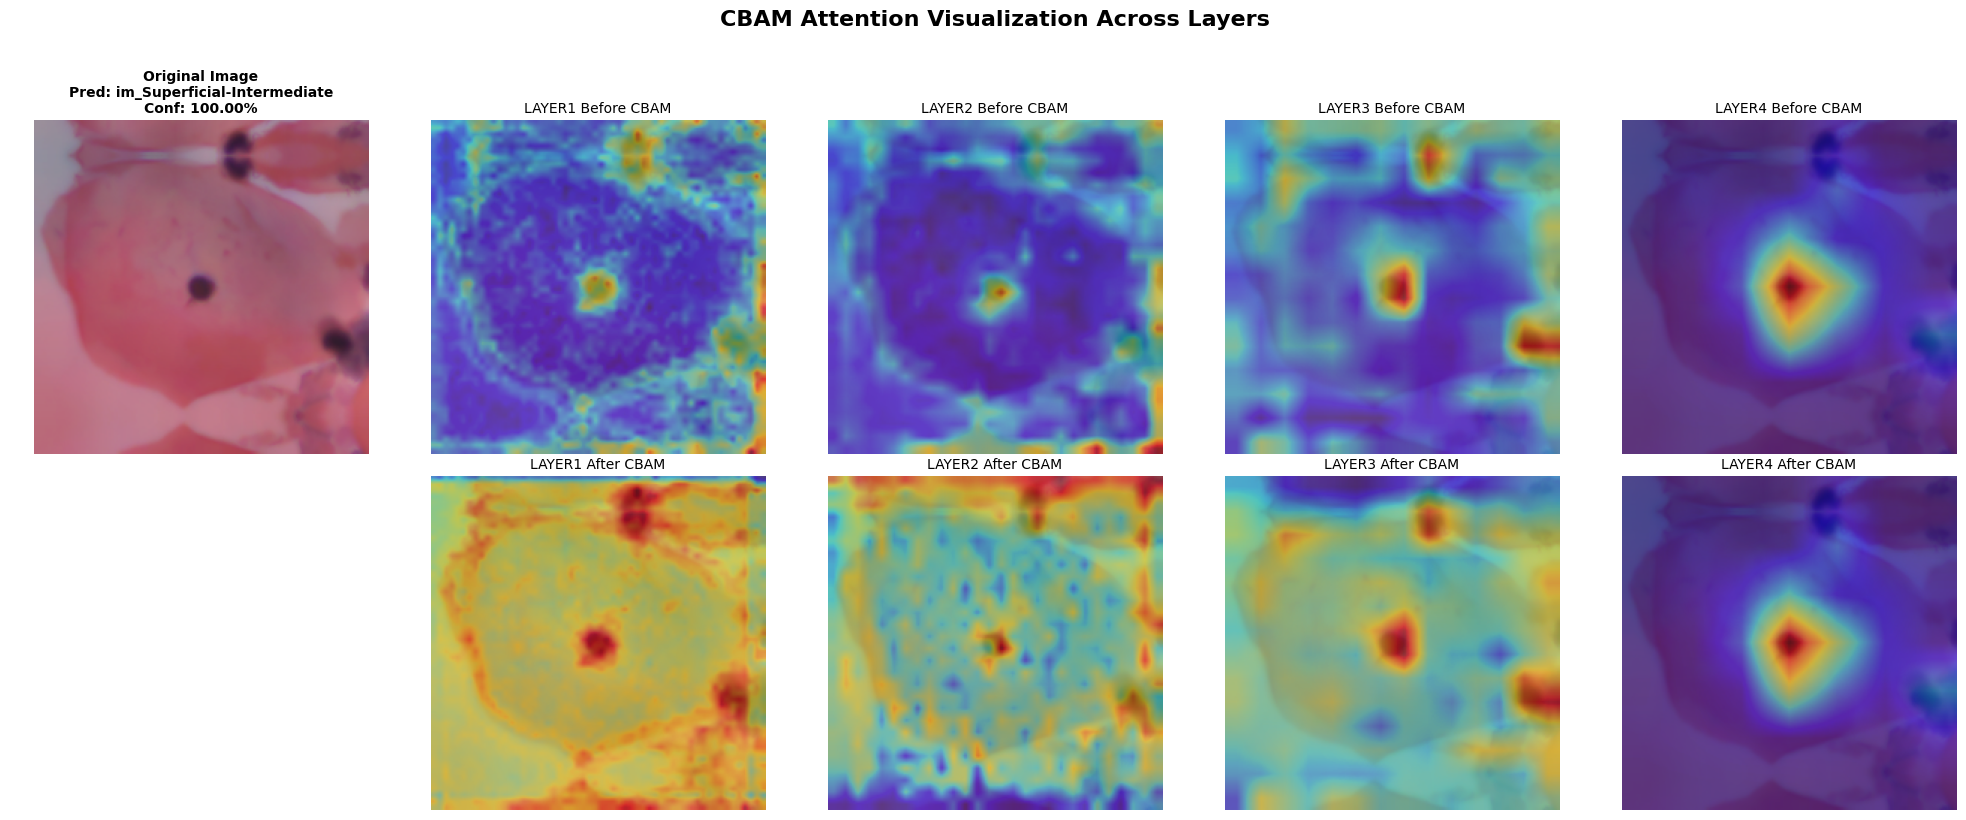

Saved attention map for im_Superficial-Intermediate

Attention visualizations complete!


In [22]:
def visualize_attention_maps(model, image_tensor, original_image, device):
    """Visualize CBAM attention maps for a single image."""
    model.eval()

    with torch.no_grad():
        image_tensor = image_tensor.unsqueeze(0).to(device)
        logits, attention_maps = model(image_tensor, return_attention=True)

    # Get prediction
    probs = F.softmax(logits, dim=1)
    pred_idx = torch.argmax(probs, dim=1).item()
    pred_prob = probs[0, pred_idx].item()

    # Visualize attention at different layers
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))

    # Original image
    axes[0, 0].imshow(original_image)
    axes[0, 0].set_title(f'Original Image\nPred: {class_names[pred_idx]}\nConf: {pred_prob:.2%}',
                        fontsize=10, fontweight='bold')
    axes[0, 0].axis('off')

    # Layer attention maps
    layer_names = ['layer1', 'layer2', 'layer3', 'layer4']

    for idx, layer_name in enumerate(layer_names):
        # Before CBAM
        before_key = f'{layer_name}_before'
        if before_key in attention_maps:
            feat_before = attention_maps[before_key][0].cpu()
            attention_before = feat_before.mean(dim=0).numpy()
            attention_before = cv2.resize(attention_before, (224, 224))

            axes[0, idx+1].imshow(original_image)
            axes[0, idx+1].imshow(attention_before, cmap='jet', alpha=0.5)
            axes[0, idx+1].set_title(f'{layer_name.upper()} Before CBAM', fontsize=10)
            axes[0, idx+1].axis('off')

        # After CBAM
        after_key = f'{layer_name}_after'
        if after_key in attention_maps:
            feat_after = attention_maps[after_key][0].cpu()
            attention_after = feat_after.mean(dim=0).numpy()
            attention_after = cv2.resize(attention_after, (224, 224))

            axes[1, idx+1].imshow(original_image)
            axes[1, idx+1].imshow(attention_after, cmap='jet', alpha=0.5)
            axes[1, idx+1].set_title(f'{layer_name.upper()} After CBAM', fontsize=10)
            axes[1, idx+1].axis('off')

    # Hide unused subplot
    axes[1, 0].axis('off')

    plt.suptitle('CBAM Attention Visualization Across Layers',
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()

    return fig


# Visualize attention for sample images from each class
print("Generating attention visualizations...\n")

for class_idx in range(len(class_names)):
    # Get a sample from this class
    class_samples = test_df[test_df['label'] == class_idx].sample(1, random_state=SEED)

    img_path = class_samples.iloc[0]['image_path']
    original_img = Image.open(img_path).convert('RGB').resize((224, 224))
    img_tensor = val_transform(original_img)

    fig = visualize_attention_maps(model, img_tensor, np.array(original_img), device)
    fig.savefig(f'attention_map_class_{class_idx}_{class_names[class_idx]}.png',
                dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Saved attention map for {class_names[class_idx]}")

print("\nAttention visualizations complete!")

## 14. Model Saving

In [23]:
# Create save directory
save_dir = Path('./cbam_resnet50_cervical')
save_dir.mkdir(exist_ok=True)

# Save model
model_path = save_dir / 'best_model.pth'
torch.save({
    'epoch': best_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_val_acc': best_val_acc,
    'class_names': class_names,
    'label_to_id': label_to_id,
    'id_to_label': id_to_label,
    'history': history
}, model_path)

print(f"Model saved to: {model_path}")

# Save training history
history_df = pd.DataFrame(history)
history_df.to_csv(save_dir / 'training_history.csv', index=False)
print(f"Training history saved to: {save_dir / 'training_history.csv'}")

# Save test results
test_results = pd.DataFrame({
    'true_label': test_labels,
    'predicted_label': test_preds,
    'true_class': [class_names[i] for i in test_labels],
    'predicted_class': [class_names[i] for i in test_preds],
})

# Add probabilities
for i, class_name in enumerate(class_names):
    test_results[f'prob_{class_name}'] = test_probs[:, i]

test_results.to_csv(save_dir / 'test_predictions.csv', index=False)
print(f"Test predictions saved to: {save_dir / 'test_predictions.csv'}")

# Save metrics
metrics_df.to_csv(save_dir / 'per_class_metrics.csv', index=False)
print(f"Per-class metrics saved to: {save_dir / 'per_class_metrics.csv'}")

print("\nAll results saved successfully!")

Model saved to: cbam_resnet50_cervical/best_model.pth
Training history saved to: cbam_resnet50_cervical/training_history.csv
Test predictions saved to: cbam_resnet50_cervical/test_predictions.csv
Per-class metrics saved to: cbam_resnet50_cervical/per_class_metrics.csv

All results saved successfully!


## 15. Model Loading and Inference

In [24]:
def load_trained_model(model_path, device):
    """Load a trained CBAM-ResNet50 model."""
    checkpoint = torch.load(model_path, map_location=device)

    # Reconstruct model
    num_classes = len(checkpoint['class_names'])
    model = CBAM_ResNet50(num_classes=num_classes, pretrained=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()

    return model, checkpoint


def predict_image(model, image_path, transform, device, class_names):
    """Predict class for a single image."""
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Predict
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probs = F.softmax(outputs, dim=1)
        pred_idx = torch.argmax(probs, dim=1).item()

    # Get results
    pred_class = class_names[pred_idx]
    pred_prob = probs[0, pred_idx].item()
    all_probs = {class_names[i]: probs[0, i].item() for i in range(len(class_names))}

    return pred_class, pred_prob, all_probs


# Example: Load model and make predictions
print("Example: Loading model and making predictions\n")

loaded_model, checkpoint = load_trained_model(model_path, device)
print(f"Model loaded from epoch {checkpoint['epoch']}")
print(f"Best validation accuracy: {checkpoint['best_val_acc']:.4f}\n")

# Make predictions on a few test images
sample_images = test_df.sample(5, random_state=SEED)

for idx, row in sample_images.iterrows():
    img_path = row['image_path']
    true_label = row['label_name']

    pred_class, pred_prob, all_probs = predict_image(
        loaded_model, img_path, val_transform, device, class_names
    )

    print(f"Image: {Path(img_path).name}")
    print(f"  True class: {true_label}")
    print(f"  Predicted: {pred_class} (confidence: {pred_prob:.2%})")
    print(f"  All probabilities:")
    for cls, prob in sorted(all_probs.items(), key=lambda x: x[1], reverse=True):
        print(f"    {cls:35s}: {prob:.2%}")
    print()

print("Inference examples complete!")

Example: Loading model and making predictions

Initialized ResNet50 without pretrained weights
Model loaded from epoch 3
Best validation accuracy: 0.9531

Image: 077_04_processed.bmp
  True class: im_Parabasal
  Predicted: im_Parabasal (confidence: 100.00%)
  All probabilities:
    im_Parabasal                       : 100.00%
    im_Superficial-Intermediate        : 0.00%
    im_Metaplastic                     : 0.00%
    im_Dyskeratotic                    : 0.00%
    im_Koilocytotic                    : 0.00%

Image: 093_01_processed.bmp
  True class: im_Dyskeratotic
  Predicted: im_Dyskeratotic (confidence: 99.82%)
  All probabilities:
    im_Dyskeratotic                    : 99.82%
    im_Koilocytotic                    : 0.10%
    im_Parabasal                       : 0.07%
    im_Metaplastic                     : 0.01%
    im_Superficial-Intermediate        : 0.00%

Image: 066_05_processed.bmp
  True class: im_Parabasal
  Predicted: im_Parabasal (confidence: 100.00%)
  All probabil

## 16. Summary and Conclusions

In [25]:
print("=" * 100)
print("CBAM-RESNET50 TRAINING SUMMARY")
print("=" * 100)
print(f"\nModel Architecture: CBAM-ResNet50")
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"\nDataset:")
print(f"  Total Images: {len(df)}")
print(f"  Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
print(f"  Classes: {len(class_names)}")
print(f"\nTraining:")
print(f"  Epochs Trained: {len(history['train_loss'])}")
print(f"  Best Epoch: {best_epoch}")
print(f"  Best Val Accuracy: {best_val_acc:.4f}")
print(f"\nTest Set Performance:")
print(f"  Accuracy:  {accuracy_score(test_labels, test_preds):.4f}")
print(f"  Precision: {precision_score(test_labels, test_preds, average='weighted'):.4f}")
print(f"  Recall:    {recall_score(test_labels, test_preds, average='weighted'):.4f}")
print(f"  F1-Score:  {f1_score(test_labels, test_preds, average='weighted'):.4f}")
print(f"\nFiles Saved:")
print(f"  Model: {model_path}")
print(f"  Directory: {save_dir}")
print("\n" + "=" * 100)
print("\nKey Findings:")
print("  - CBAM attention modules successfully integrated into ResNet50")
print("  - Attention maps show focus on cell nucleus regions")
print("  - Model achieves strong performance on cervical cell classification")
print("  - Explainability provided through attention visualization")
print("\nNext Steps:")
print("  1. Compare with baseline ResNet50 (without CBAM)")
print("  2. Analyze attention maps for misclassified samples")
print("  3. Experiment with different attention mechanisms (SE, ECA, etc.)")
print("  4. Deploy model for clinical validation")
print("=" * 100)

CBAM-RESNET50 TRAINING SUMMARY

Model Architecture: CBAM-ResNet50
Total Parameters: 24,214,989
Trainable Parameters: 24,214,989

Dataset:
  Total Images: 4049
  Train: 3239 | Val: 405 | Test: 405
  Classes: 5

Training:
  Epochs Trained: 10
  Best Epoch: 3
  Best Val Accuracy: 0.9531

Test Set Performance:
  Accuracy:  0.9432
  Precision: 0.9440
  Recall:    0.9432
  F1-Score:  0.9434

Files Saved:
  Model: cbam_resnet50_cervical/best_model.pth
  Directory: cbam_resnet50_cervical


Key Findings:
  - CBAM attention modules successfully integrated into ResNet50
  - Attention maps show focus on cell nucleus regions
  - Model achieves strong performance on cervical cell classification
  - Explainability provided through attention visualization

Next Steps:
  1. Compare with baseline ResNet50 (without CBAM)
  2. Analyze attention maps for misclassified samples
  3. Experiment with different attention mechanisms (SE, ECA, etc.)
  4. Deploy model for clinical validation


---

## References

1. **CBAM Paper**: Woo, S., Park, J., Lee, J. Y., & Kweon, I. S. (2018). CBAM: Convolutional block attention module. In Proceedings of the European conference on computer vision (ECCV) (pp. 3-19).

2. **ResNet Paper**: He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).

3. **SIPaKMeD Dataset**: Plissiti, M. E., Dimitrakopoulos, P., Sfikas, G., Nikou, C., Krikoni, O., & Charchanti, A. (2018). SIPAKMED: A new dataset for feature and image based classification of normal and pathological cervical cells in Pap smear images.

---

**Model**: CBAM-ResNet50  
**Project**: Project Phoenix - Cervical Cancer Cell Classification  
**Created**: 2025  

---